In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pm4py
import scipy
import stormpy
from copy import deepcopy
import numpy as np

In [3]:
from simulation.markov_models import log_parser
from simulation.markov_chain import apply as mc_apply
from simulation.markov_chain_vis import view_markov_chain, view_resource_markov_chain, view_non_resource_markov_chain
import simulation.util as sim_util

# Synthetic event log generation

In [4]:
make_repetitions = True

In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon, sem, t, kstest
from datetime import datetime, timedelta

# Simulation parameters
np.random.seed(42)
num_traces = 1000
event_labels = ["Start", "Middle", "End"]

rate_for_test = 0.25

# Time unit configuration: choose "seconds" or "hours"
time_unit = "hours"  # or "seconds"
time_factor = 1 if time_unit == "seconds" else 1 / 3600  # seconds to chosen unit

# Generate synthetic event log
rows = []
for case_id in range(1, num_traces + 1):
    current_time = datetime.now()
    case_id_str = str(case_id)

    rows.append({
        "case:concept:name": case_id_str,
        "concept:name": "Start",
        "org:role": "R1",
        "org:resource": "R1",
        "time:timestamp": current_time
    })
    go_middle = bool(random.getrandbits(1))
    number_of_times = int(random.uniform(1, 5))
    if not make_repetitions:
        number_of_times = 1
    if go_middle:
        for repetition in range(number_of_times):
            # current_time += timedelta(hours=np.random.normal(loc=8.0, scale=1.0))
            current_time += timedelta(seconds=np.random.exponential(3600/rate_for_test))  # convert hours to seconds

            rows.append({
                "case:concept:name": case_id_str,
                "concept:name": "Middle",
                "org:role": "R1",
                "org:resource": "R1",
                "time:timestamp": current_time
            })

    # current_time += timedelta(hours=np.random.normal(loc=8.0, scale=1.0))
    current_time += timedelta(seconds=np.random.exponential(3600/rate_for_test))
    rows.append({
        "case:concept:name": case_id_str,
        "concept:name": "End",
        "org:role": "R1",
        "org:resource": "R1",
        "time:timestamp": current_time
    })

# Create DataFrame
df = pd.DataFrame(rows)
df["time:timestamp"] = pd.to_datetime(df["time:timestamp"])
df = df.sort_values(by=["case:concept:name", "time:timestamp"]).reset_index(drop=True)

epsilon = 3
final_states = ['End']

from simulation.unfold_events import rename_repeating_events

df, final_states = rename_repeating_events(df,epsilon,final_states)

# Extract time deltas in desired unit
time_diffs = {}
for case_id, group in df.groupby("case:concept:name"):
    events = group["concept:name"].tolist()
    times = group["time:timestamp"].tolist()
    for i in range(len(events) - 1):
        pair = (events[i], events[i + 1])
        delta_time = (times[i + 1] - times[i]).total_seconds() * time_factor
        time_diffs.setdefault(pair, []).append(delta_time)


In [6]:
time_diffs.keys()

dict_keys([('Start1', 'Middle1'), ('Middle1', 'Middle2'), ('Middle2', 'Middle3'), ('Middle3', 'End1'), ('Start1', 'End1'), ('Middle2', 'End1'), ('Middle1', 'End1'), ('Middle3', 'Middle3')])

In [7]:
true_rates = {}
for k,v in time_diffs.items():
    true_rates[k] = rate_for_test

# Exponential fit and statistical hypothesis tests

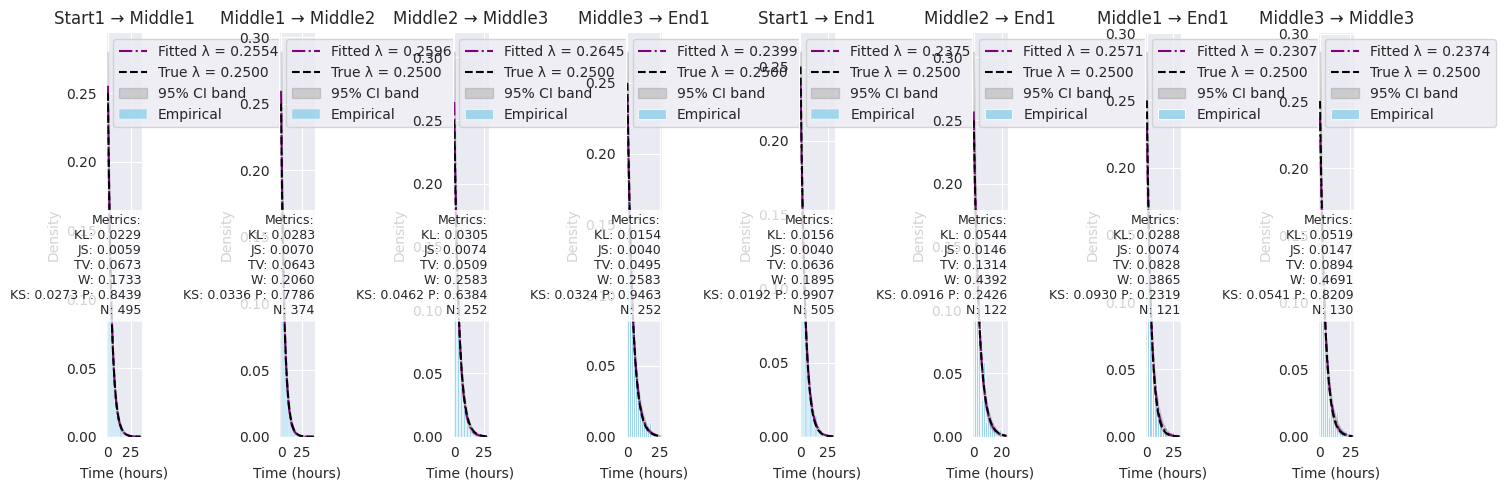

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon, sem, t, entropy, kstest
from scipy.special import rel_entr, kl_div
from scipy.stats import wasserstein_distance
from datetime import datetime, timedelta

def compute_freedman_diaconis_bins(data):
    iqr = np.subtract(*np.percentile(data, [75, 25]))
    bin_width = 2 * iqr / (n ** (1/3))
    return int(np.ceil((np.max(data) - np.min(data)) / bin_width)) if bin_width > 0 else 1

# ---- Plot and Compute Distances ----
fig, axes = plt.subplots(1, len(time_diffs), figsize=(14, 5))
metrics_all = {}

for ax, (pair, deltas) in zip(axes, time_diffs.items()):
    deltas = np.array(deltas)
    mean_time = deltas.mean()
    n = len(deltas)

    # Manual fit
    rate_manual = 1 / mean_time
    ci_half_width = t.ppf(0.975, df=n-1) * sem(deltas)
    lower_rate = 1 / (mean_time + ci_half_width)
    upper_rate = 1 / (mean_time - ci_half_width)

    # Scipy fit
    loc, scale = expon.fit(deltas, floc=0)
    rate_scipy = 1 / scale

    # True rate
    if true_rates and pair in true_rates:
        rate_true = true_rates[pair]
        if time_unit == "seconds":
            rate_true /= 3600  # convert per hour to per second

    # Histogram
    num_bins = compute_freedman_diaconis_bins(deltas)
    counts, bin_edges = np.histogram(deltas, bins=num_bins, density=False)
    bin_widths = np.diff(bin_edges)
    total = np.sum(counts)
    hist_probs = counts / total

    # Model probabilities over bins
    model_probs = expon.cdf(bin_edges[1:], scale=1 / rate_scipy) - expon.cdf(bin_edges[:-1], scale=1 / rate_scipy)
    eps = 1e-12
    # kldiv = np.sum(rel_entr(hist_probs, model_probs))
    test_kl_div = entropy(hist_probs, model_probs)
    test2_kl_div = np.sum(kl_div(hist_probs, model_probs))
    ks_test, ks_p_value = kstest(deltas, lambda deltas: expon.cdf(deltas,loc,scale))
    m = 0.5 * (hist_probs + model_probs)
    js_div = 0.5 * (entropy(hist_probs + eps, m + eps) + entropy(model_probs + eps, m + eps))
    tv_dist = 0.5 * np.sum(np.abs(hist_probs - model_probs))
    w_dist = wasserstein_distance(deltas, expon.rvs(scale=1 / rate_scipy, size=len(deltas), random_state=42))

    # Save metrics
    metrics_all[pair] = {
        "kl_divergence": test_kl_div,
        "js_divergence": js_div,
        "total_variation": tv_dist,
        "wasserstein_distance": w_dist,
        "ks_test": ks_test,
        "ks_p_value": ks_p_value,
        "n": n
    }

    # Plot histogram and fits
    sns.histplot(deltas, bins=num_bins, stat="density", ax=ax, color="skyblue", label="Empirical")
    x_vals = np.linspace(0, max(deltas) * 1.2, 200)
    ax.plot(x_vals, expon.pdf(x_vals, scale=1 / rate_scipy), linestyle="-.", color="purple",
            label=f"Fitted λ = {rate_scipy:.4f}")
    if rate_true:
        ax.plot(x_vals, expon.pdf(x_vals, scale=1 / rate_true), linestyle="dashed", color="black",
                label=f"True λ = {rate_true:.4f}")
    ax.fill_between(x_vals,
                    expon.pdf(x_vals, scale=1 / lower_rate),
                    expon.pdf(x_vals, scale=1 / upper_rate),
                    color="gray", alpha=0.3, label="95% CI band")

    ax.set_title(f"{pair[0]} → {pair[1]}")
    ax.set_xlabel(f"Time ({time_unit})")
    ax.set_ylabel("Density")
    ax.legend()

    # Text box with metrics
    textstr = 'Metrics:\n'
    textstr += '\n'.join([
        f"KL: {test_kl_div:.4f}",
        f"JS: {js_div:.4f}",
        f"TV: {tv_dist:.4f}",
        f"W: {w_dist:.4f}",
        f"KS: {ks_test:.4f} P: {ks_p_value:.4f}",
        f"N: {n}"
    ])
    ax.text(0.98, 0.55, textstr,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# If needed later:
# print(metrics_all)


--- Aggregated Metrics ---
KL Divergence (weighted): 0.0259
JS Divergence (weighted): 0.0067
Total Variation Distance (mean): 0.0749
Wasserstein Distance (mean): 0.2975
KS Test (mean): 0.0497
KS p-value (combined fisher): 0.9484
Total Samples: 2251.0000


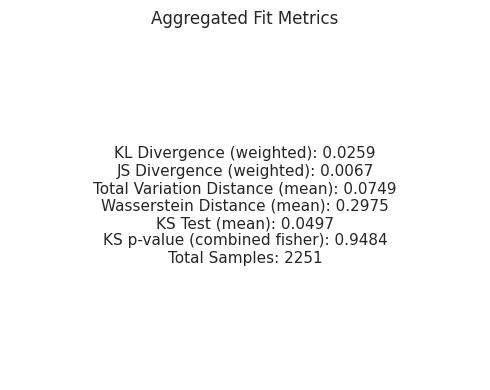

In [9]:
from scipy.stats import combine_pvalues

total_n = sum(m["n"] for m in metrics_all.values())

# Weighted averages for divergence metrics
kl_weighted = sum(m["kl_divergence"] * m["n"] for m in metrics_all.values()) / total_n
js_weighted = sum(m["js_divergence"] * m["n"] for m in metrics_all.values()) / total_n

# Simple averages for bounded or scale-sensitive distances
tv_average = np.mean([m["total_variation"] for m in metrics_all.values()])
w_average = np.mean([m["wasserstein_distance"] for m in metrics_all.values()])

ks_average = np.mean([m["ks_test"] for m in metrics_all.values()])
stat, ks_combined_p = combine_pvalues([m["ks_p_value"] for m in metrics_all.values()])
# Final aggregate summary
aggregate_metrics = {
    "KL Divergence (weighted)": kl_weighted,
    "JS Divergence (weighted)": js_weighted,
    "Total Variation Distance (mean)": tv_average,
    "Wasserstein Distance (mean)": w_average,
    "KS Test (mean)": ks_average,
    "KS p-value (combined fisher)": ks_combined_p,
    "Total Samples": total_n
}

# Print aggregated metrics
print("\n--- Aggregated Metrics ---")
for key, val in aggregate_metrics.items():
    print(f"{key}: {val:.4f}")

# ---- Display in a New Figure ----
fig_summary, ax_summary = plt.subplots(figsize=(5, 4))
ax_summary.axis("off")

summary_text = '\n'.join([
    f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}"
    for k, v in aggregate_metrics.items()
])

ax_summary.text(0.5, 0.5, summary_text,
                fontsize=11,
                ha="center",
                va="center",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))

ax_summary.set_title("Aggregated Fit Metrics")
plt.tight_layout()
plt.show()

In [10]:
import pm4py

pm4py.write_xes(df, "test.xes")

/home/vco/.pyenv/versions/pn-updater/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
exporting log, completed traces :: 100%|██████████| 1000/1000 [00:00<00:00, 18140.51it/s]


# Building the ctmc and running it

In [11]:
subset_el = pm4py.convert_to_event_log(df)
subset_el = log_parser.add_start_end(subset_el)
dfg, start_activities, end_activities = pm4py.discover_dfg(subset_el)
dfg["end", "start"] = 1

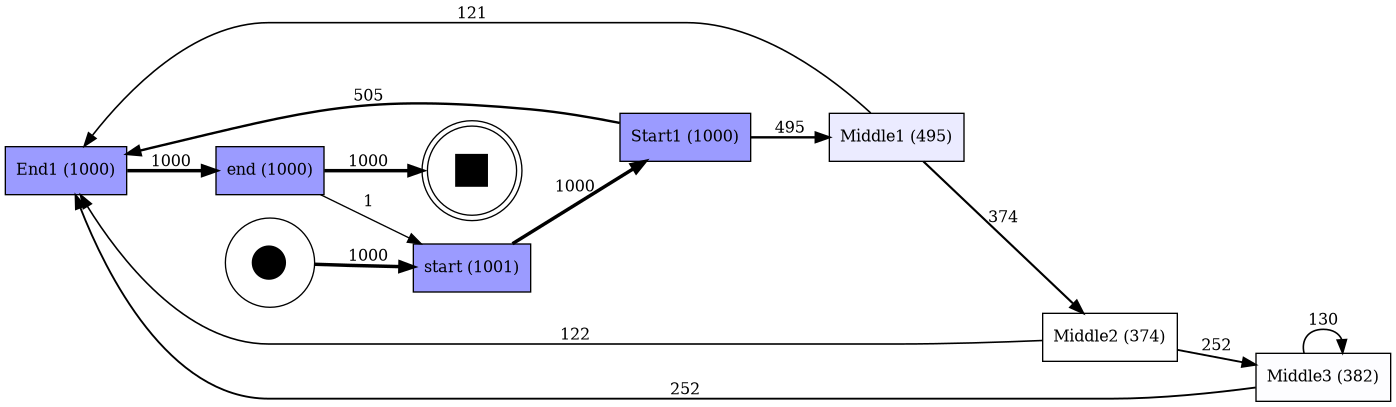

In [12]:
pm4py.view_dfg(dfg, start_activities, end_activities)

In [13]:
subset_el = pm4py.convert_to_dataframe(subset_el)

In [14]:
from simulation.timings import Timings

In [15]:
timings = Timings()
resource_input_array = timings.create_resource_input_array_from_log(subset_el)
res_timings = timings.get_timings_per_resource(subset_el, resource_input_array)
times_dictionary = res_timings

In [16]:
data_transition_role_frequency = sim_util.get_transition_resource_dict(subset_el)

In [17]:
data_mean_transition_role_time = {}
tuples_to_discard = set()
for k,v in data_transition_role_frequency.items():
    if k in ['start','end']:
        continue
    for k2,v2 in v.items():
        if k2 in ['start','end']:
            continue
        all_freq = 0
        for k3,v3 in v2.items():
            all_freq += v3
            if (k,k2,k3) in times_dictionary:
                times = times_dictionary[(k,k2,k3)]
                times = np.array(times)
                times = times/3600
                times = times[times != 0]
                if len(times) > 1: # only take times that have more than 1 value
                    expon_loc, expon_scale = scipy.stats.expon.fit(times)

                    # f = Fitter(times, distributions=['expon'])
                    # f.fit()
                    # best = f.get_best()['expon']
                    # expon_loc_fitter, expon_scale_fitter = best['loc'], best['scale']

                    if expon_scale>0: # do not take times that cannot be fit into an exponential
                        rate = 1/expon_scale
                        if k not in data_mean_transition_role_time:
                            data_mean_transition_role_time[k] = {}
                        if k2 not in data_mean_transition_role_time[k]:
                            data_mean_transition_role_time[k][k2] = {}
                        if k3 not in data_mean_transition_role_time[k][k2]:
                            data_mean_transition_role_time[k][k2][k3] = {
                                # 'loc': expon_loc_fitter,
                                # 'scale': expon_scale_fitter,
                                'loc': expon_loc,
                                'scale': expon_scale,
                                'lambda': rate
                            }
                    else:
                        print(f"[No exponential!] {k},{k2},{k3}")
                        tuples_to_discard.add((k,k2,k3))
                        print(times)
                else:
                    print(f"[No times!] {k},{k2},{k3}")
                    tuples_to_discard.add((k,k2,k3))
                    print(times)

In [18]:
for (e_from,e_to,role) in tuples_to_discard:
    if e_from in data_transition_role_frequency:
        if e_to in data_transition_role_frequency[e_from]:
            if role in data_transition_role_frequency[e_from][e_to]:
                data_transition_role_frequency[e_from][e_to].pop(role)

In [19]:
for e_from in data_transition_role_frequency.keys():
    for e_to in data_transition_role_frequency.keys():
        if (e_from == 'start' and e_to == 'start') or (e_from == 'end' and e_to == 'end'):
            data_transition_role_frequency[e_from].pop(e_to)

In [20]:
def remove_empty_keys(d):
    """Recursively remove empty keys from a three-level nested dictionary."""
    if not isinstance(d, dict):
        return d  # Return non-dict values as they are

    cleaned_dict = {}
    for key, value in d.items():
        if isinstance(value, dict):
            cleaned_value = remove_empty_keys(value)  # Recursively clean sub-dictionaries
            if cleaned_value:  # Add only if not empty
                cleaned_dict[key] = cleaned_value
        elif value not in (None, "", [], {}, ()):  # Ignore empty values
            cleaned_dict[key] = value

    return cleaned_dict

data_transition_role_frequency = remove_empty_keys(data_transition_role_frequency)

In [21]:
role_resources = sim_util.get_detailed_weighted_role(subset_el)

In [22]:
role_trials = {k:int(v) for k,v in role_resources.items()}

In [23]:
res = {}
out_frequency = {}
data_transition_role_prob = {}

for k,v in data_transition_role_frequency.items():
    if k in ['start','end']:
        continue
    out_freq = 0
    if k not in data_transition_role_prob:
        data_transition_role_prob[k] = {}

    for k2,v2 in v.items():
        if k2 in ['start','end']:
            continue
        all_freq = 0

        if k2 not in data_transition_role_prob[k]:
            data_transition_role_prob[k][k2] = {}

        if k not in res:
            res[k] = {}
        if k2 not in res[k]:
            for k3,v3 in v2.items():
                if k3 not in data_transition_role_prob[k][k2]:
                    data_transition_role_prob[k][k2][k3] = v3
                all_freq += v3
            res[k][k2] = all_freq
            out_freq += all_freq
        out_frequency[k] = out_freq

for k,v in res.items():
    for k2,v2 in v.items():
        res[k][k2] = res[k][k2]/out_frequency[k]

for k,v in data_transition_role_prob.items():
    for k2,v2 in v.items():
        for k3,v3 in v2.items():
            data_transition_role_prob[k][k2][k3] = v3/out_frequency[k]

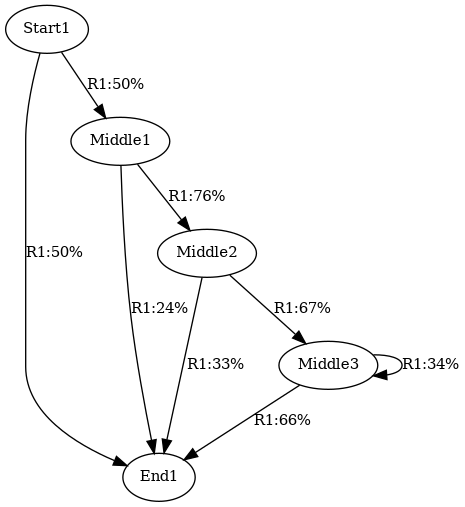

In [24]:
view_resource_markov_chain(data_transition_role_prob)

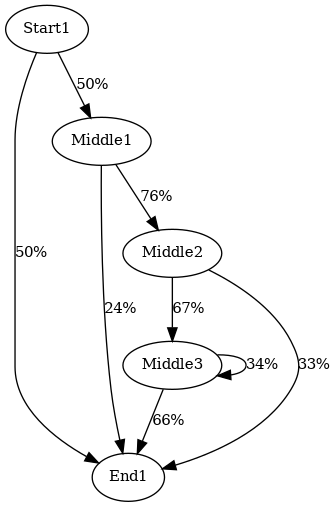

In [25]:
view_non_resource_markov_chain(res)

In [26]:
states = set(subset_el['concept:name'].unique()).difference(set(['start','end']))
n = len(states)
i = 0
correspondence = {s:i for s,i in zip(states,range(len(states)))}
#TODO: make sure none of the final states have state = 0 in the prism program
non_final_states = list(states.difference(set(final_states)))
for s in final_states:
    if correspondence[s] == 0:
        correspondence[s] = correspondence[non_final_states[0]]
        correspondence[non_final_states[0]] = 0
correspondence

{'Start1': 0, 'Middle1': 1, 'Middle3': 2, 'End1': 3, 'Middle2': 4}

In [27]:
gt_data_mean_transition_role_time = deepcopy(data_mean_transition_role_time)

def replace_lambda_values(d, new_value):
    for key, value in d.items():
        if isinstance(value, dict):
            replace_lambda_values(value, new_value)
        elif key == "lambda":
            d[key] = new_value

replace_lambda_values(gt_data_mean_transition_role_time,0.25)

In [28]:
from simulation.ctmc import create_prism_program_from_log

probabilities = create_prism_program_from_log(
                            correspondence,
                            final_states,
                            data_mean_transition_role_time,
                            role_resources,
                            data_transition_role_frequency,
                            role_trials,
                            'ctmc.sm')

gt_probabilities = create_prism_program_from_log(
                            correspondence,
                            final_states,
                            gt_data_mean_transition_role_time,
                            role_resources,
                            data_transition_role_frequency,
                            role_trials,
                            'ctmc-gt.sm')
# print(probabilities)

In [29]:
prism_program = stormpy.parse_prism_program('ctmc.sm',prism_compat=True,simplify=True)
gt_prism_program = stormpy.parse_prism_program('ctmc-gt.sm',prism_compat=True,simplify=True)

In [30]:
model = stormpy.build_model(prism_program)
gt_model = stormpy.build_model(gt_prism_program)
# print("Number of states: {}".format(model.nr_states))
# print("Number of transitions: {}".format(model.nr_transitions))
# print("Labels: {}".format(model.labeling.get_labels()))


# formula_str = f'R=? [F {labels}]'
# formula_str = f'Rmin=? [C]'

def get_result(model, prism_program):
    labels = ""
    for fs in final_states:
        labels += f'"q_terminal_{fs}" |'
    labels = labels[:-2]
    formula_str = f'Tmin=? [F {labels}]'
    properties = stormpy.parse_properties(formula_str, prism_program)
    result = stormpy.model_checking(model, properties[0])
    initial_state = model.initial_states[0]
    result = result.at(initial_state)
    print(f"Hours: {result}")
    if result<np.inf:
        if time_unit == 'hours':
            print(f"Duration: {timedelta(hours=result)}")
        else:
            print(f"Duration: {timedelta(seconds=result)}")
    return result

result = get_result(model,prism_program)
gt_result = get_result(gt_model,gt_prism_program)

Hours: 4.153084206016959
Duration: 4:09:11.103142
Hours: 4.0
Duration: 4:00:00


# Analysis between ground truth, result and metrics

In [31]:
metrics_all

{('Start1', 'Middle1'): {'kl_divergence': 0.0229162855603695,
  'js_divergence': 0.005868927851148953,
  'total_variation': 0.0672540528241091,
  'wasserstein_distance': 0.17330517264409967,
  'ks_test': 0.027313443888405287,
  'ks_p_value': 0.8438589125681077,
  'n': 495},
 ('Middle1', 'Middle2'): {'kl_divergence': 0.028279834485744046,
  'js_divergence': 0.0070444893132675344,
  'total_variation': 0.06425950922010473,
  'wasserstein_distance': 0.20598974839879142,
  'ks_test': 0.033622769877044156,
  'ks_p_value': 0.7785627390349519,
  'n': 374},
 ('Middle2', 'Middle3'): {'kl_divergence': 0.030477361597664523,
  'js_divergence': 0.007428560430889227,
  'total_variation': 0.050918813329107714,
  'wasserstein_distance': 0.25830403038479566,
  'ks_test': 0.04618130999353737,
  'ks_p_value': 0.638435644376431,
  'n': 252},
 ('Middle3', 'End1'): {'kl_divergence': 0.015447161342272748,
  'js_divergence': 0.0039873518851068455,
  'total_variation': 0.04947329810955496,
  'wasserstein_distan

In [32]:
abs(result - gt_result)

0.15308420601695882

# Resource Regression Analysis

In [33]:
import random

durations = []
# x = list(range(1,50))
samples = 500
for i in range(samples):
    regression_role_trials = {}
    for k,v in role_trials.items():
        random_resource_number = abs(random.gauss(v,v/2))
        regression_role_trials[k] = random_resource_number
    probabilities = create_prism_program_from_log(
                            correspondence,
                            final_states,
                            data_mean_transition_role_time,
                            role_resources,
                            data_transition_role_frequency,
                            regression_role_trials,
                            'ctmc.sm')
    prism_program = stormpy.parse_prism_program('ctmc.sm', prism_compat=True, simplify=True)
    model = stormpy.build_model(prism_program)
    labels = ""
    for fs in final_states:
        labels += f'"q_terminal_{fs}" |'
    labels = labels[:-2]

    formula_str = f'Tmin=? [F {labels}]'
    properties = stormpy.parse_properties(formula_str, prism_program)
    result = stormpy.model_checking(model, properties[0])
    initial_state = model.initial_states[0]
    result = result.at(initial_state)
    durations.append({**regression_role_trials, "duration": result})
    # print(f'{i}/{samples}')

In [34]:
durations_df = pd.DataFrame(durations)
durations_df

,R1,duration
0,0.628306,6.609967
1,1.567619,2.649295
2,0.105984,39.185894
3,0.173709,23.908343
4,0.263245,15.776487
...,...,...
495,1.480605,2.804992
496,0.769165,5.399474
497,0.496776,8.360068
498,0.796297,5.215498


In [35]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Example: Load your DataFrame
# df = pd.read_csv("your_data.csv")

def run_linear_regression(df, target_column, fit_intercept=True):
    # Split into X (features) and y (target)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Fit model
    model = LinearRegression(fit_intercept=fit_intercept)
    model.fit(X, y)

    # Print model coefficients
    intercept = model.intercept_
    coef = model.coef_

    print("Intercept:", intercept if fit_intercept else "Not used")
    print("Coefficients:")
    for col, weight in zip(X.columns, coef):
        print(f"{col}: {weight:.4f}")

    return model, X.columns, coef

def rank_features_by_importance(X, coef):
    importance_df = pd.DataFrame({
        'Feature': X,
        'Coefficient': coef,
        'Importance (abs)': abs(coef)
    })
    return importance_df.sort_values(by='Importance (abs)', ascending=False)

# Run regression
model, features, coefs = run_linear_regression(durations_df, 'duration', fit_intercept=False)

# Rank features
ranking = rank_features_by_importance(features, coefs)
print("\nFeature Ranking:\n", ranking)

Intercept: Not used
Coefficients:
R1: 3.4878

Feature Ranking:
   Feature  Coefficient  Importance (abs)
0      R1      3.48779           3.48779


# Other stuff and old stuff not used

/tmp/ipykernel_43346/251997476.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


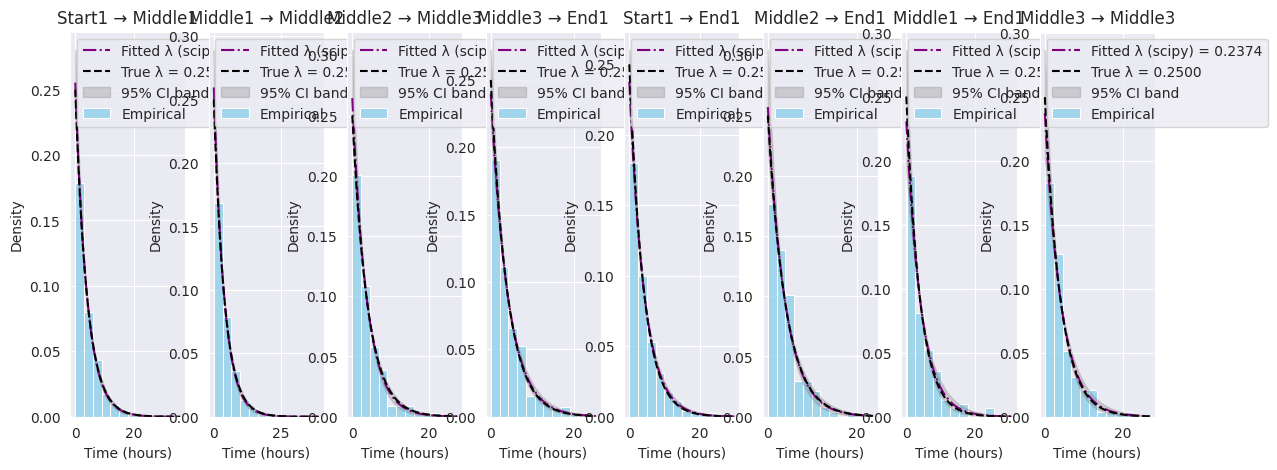

In [36]:
# Plot histogram and exponential fits
fig, axes = plt.subplots(1, len(time_diffs), figsize=(14, 5))

for ax, (pair, deltas) in zip(axes, time_diffs.items()):
    deltas = np.array(deltas)
    mean_time = deltas.mean()
    n = len(deltas)

    # Manual exponential fit
    rate_manual = 1 / mean_time
    ci_half_width = t.ppf(0.975, df=n-1) * sem(deltas)
    lower_rate = 1 / (mean_time + ci_half_width)
    upper_rate = 1 / (mean_time - ci_half_width)

    # Scipy fit with loc fixed to 0
    loc, scale = expon.fit(deltas, floc=0)
    rate_scipy = 1 / scale

    # True rate
    rate_true = true_rates[pair]
    if time_unit == "seconds":
        rate_true /= 3600  # convert per hour to per second

    # Plot histogram
    sns.histplot(deltas, bins=10, stat="density", ax=ax, color="skyblue", label="Empirical")

    # X values for plotting
    x_vals = np.linspace(0, max(deltas) * 1.2, 200)

    # PDF curves
    # ax.plot(x_vals, expon.pdf(x_vals, scale=1 / rate_manual), color="darkblue",
    #         label=f"Fitted λ (manual) = {rate_manual:.4f}")
    ax.plot(x_vals, expon.pdf(x_vals, scale=1 / rate_scipy), linestyle="-.", color="purple",
        label=f"Fitted λ (scipy) = {rate_scipy:.4f}")
    ax.plot(x_vals, expon.pdf(x_vals, scale=1 / rate_true), linestyle="dashed", color="black",
            label=f"True λ = {rate_true:.4f}")
    ax.fill_between(x_vals,
                    expon.pdf(x_vals, scale=1 / lower_rate),
                    expon.pdf(x_vals, scale=1 / upper_rate),
                    color="gray", alpha=0.3, label="95% CI band")

    # Labels and titles
    ax.set_title(f"{pair[0]} → {pair[1]}")
    ax.set_xlabel(f"Time ({time_unit})")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

In [37]:
def extract_times_event_log(log_input):
    if type(log_input) == pd.DataFrame:
        log = pm4py.convert_to_event_log(deepcopy(log_input))
    else:
        log = deepcopy(log_input)
    times = []
    for trace in log:
        start = trace[0]['time:timestamp']
        end = trace[len(trace)-1] ['time:timestamp']
        time = end - start
        times.append(time.total_seconds())
    return times

def extract_times_with_future(log_input):
    times_dictionary = {}
    if type(log_input) == pd.DataFrame:
        log = pm4py.convert_to_event_log(deepcopy(log_input))
    else:
        log = deepcopy(log_input)
    for trace in log:
        first = True
        for next_event in trace:
            if not first and next_event['concept:name'] != 'end' and event['concept:name'] != 'start':
                time = next_event['time:timestamp'] - event['time:timestamp']
                if not (event['concept:name'], next_event['concept:name']) in times_dictionary.keys():
                    times_dictionary[(event['concept:name'], next_event['concept:name'])] = [time.total_seconds()]
                else:
                    times_dictionary[(event['concept:name'], next_event['concept:name'])].append(time.total_seconds())
            event = next_event
            first = False
    return times_dictionary

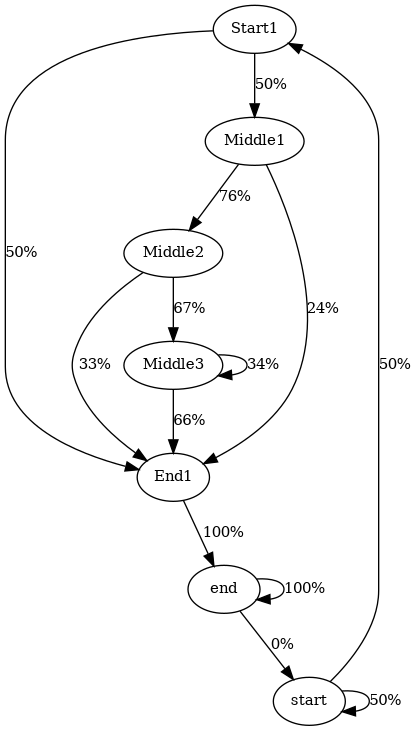

In [38]:
semi_markov_json = mc_apply(subset_el)
view_markov_chain(semi_markov_json)

In [39]:
# prism_program = stormpy.parse_prism_program('ctmc_simple_choice.sm',prism_compat=True,simplify=True)
prism_program = stormpy.parse_prism_program('ctmc_basic.sm',prism_compat=True,simplify=True)
model = stormpy.build_model(prism_program)
# print("Number of states: {}".format(model.nr_states))
# print("Number of transitions: {}".format(model.nr_transitions))
# print("Labels: {}".format(model.labeling.get_labels()))
labels = ""
for fs in final_states:
    labels += f'"q_terminal_{fs}" |'
labels = labels[:-2]

formula_str = f'R=? [F {labels}]'
properties = stormpy.parse_properties(formula_str, prism_program)
result = stormpy.model_checking(model, properties[0])
initial_state = model.initial_states[0]
result = result.at(initial_state)
print(f"Hours: {result}")
if result<np.inf:
    print(f"Duration: {timedelta(seconds=result)}")

 WARN (Program.cpp:238): The input model is a CTMC, but uses probabilistic commands like they are used in PRISM. Consider rewriting the commands to use Markovian commands instead.
ERROR (SparsePropositionalModelChecker.cpp:48): The property refers to unknown label 'q_terminal_End1'.


RuntimeError: InvalidPropertyException: The property refers to unknown label 'q_terminal_End1'.

In [86]:
data_mean_transition_role_time

{'Start': {'Middle': {'R1': {'loc': 0.020297748333333334,
    'scale': 4.264084915203252,
    'lambda': 0.23451690571043282}},
  'End': {'R1': {'loc': 0.02097334333333333,
    'scale': 3.8606968702805116,
    'lambda': 0.2590205948822244}}},
 'Middle': {'End': {'R1': {'loc': 0.030366474166666664,
    'scale': 3.921478933249401,
    'lambda': 0.2550058324988587}},
  'Middle2': {'R1': {'loc': 0.012893813333333332,
    'scale': 4.069583670951369,
    'lambda': 0.2457253814777138}}},
 'Middle2': {'Middle3': {'R1': {'loc': 0.018571136388888892,
    'scale': 4.187560381676163,
    'lambda': 0.23880252673508387}},
  'End': {'R1': {'loc': 0.025625394444444442,
    'scale': 3.6814793320401495,
    'lambda': 0.27162993726378853}}},
 'Middle3': {'End': {'R1': {'loc': 0.019808891944444445,
    'scale': 3.7527075791559827,
    'lambda': 0.26647426662135737}},
  'Middle3': {'R1': {'loc': 0.06690779027777778,
    'scale': 3.742852565506536,
    'lambda': 0.2671758992635249}}}}

In [87]:
pm4py.get_cycle_time(subset_el)

0.0

In [88]:
pm4py.get_all_case_durations(subset_el)

[75.504036,
 141.392094,
 259.712681,
 264.814385,
 264.972162,
 267.291179,
 299.510035,
 309.583644,
 384.779763,
 420.552309,
 438.220525,
 455.458307,
 456.187375,
 462.178753,
 486.242578,
 491.148574,
 517.678233,
 536.174523,
 541.21648,
 577.993196,
 669.765049,
 684.919436,
 711.547184,
 810.981349,
 845.957186,
 857.99532,
 862.904161,
 965.551371,
 970.957265,
 973.446318,
 999.821532,
 1028.893068,
 1035.131836,
 1036.099595,
 1039.462633,
 1063.434628,
 1079.098154,
 1094.588471,
 1103.923814,
 1107.781423,
 1115.652511,
 1124.791283,
 1153.501611,
 1165.280896,
 1178.46273,
 1210.113246,
 1221.822008,
 1227.725935,
 1228.254197,
 1251.27084,
 1255.017965,
 1265.119512,
 1275.896659,
 1324.352406,
 1377.17203,
 1405.476129,
 1445.933049,
 1472.086042,
 1482.579626,
 1486.545352,
 1508.256482,
 1529.644831,
 1546.312005,
 1644.011067,
 1673.81934,
 1688.311945,
 1709.179508,
 1735.763348,
 1773.361506,
 1781.464025,
 1804.047031,
 1810.801726,
 1834.162468,
 1850.079852,
 1

In [89]:
mean, median, margin_of_error = sim_util.get_pm4py_reference_times(subset_el)
print(timedelta(seconds=median))
print(timedelta(seconds=mean))
print(timedelta(seconds=margin_of_error))

6:09:03.101818
8:49:54.250957
0:31:14.499242


In [90]:
middle_mean = np.mean(times_dictionary[('Start','Middle','R1')]) + np.mean(times_dictionary[('Middle','End','R1')])
start_end_mean = np.mean(times_dictionary[('Start','End','R1')])
mean_all = np.mean([middle_mean, start_end_mean])
print(timedelta(seconds=mean_all))

6:03:32.216912
